I'm going to try to learn a CNN that reproduces the signal processing of a microscope. I'm going to train on some images that I believe are "bags of GFP" -- Colleen's IDRs and Zelda C-terminal fragments. I measure the concentration of these via the standard candles, that means I can make a reasonable simulation of the "true image" — just n fluors randomly distributed within the mask. I can make a lot of sims for each real image. The CNN needs to output an n X n X n image, the loss function is some simple measure of pixel intensity difference (I think mean difference per non-zero pixel? Obvi can try multiple things).

Workflow:

1. Make an initial training set (simulations of real c-terminal nuclei with 80 nM free)
2. Design a 1 conv layer network to test (just get it to ouput proper size and test loss function)

In [4]:
from importlib import reload
import flymovie as fm
import cnn_models.siamese_cnn as cn
import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import string
import tensorflow as tf
import pickle
from importlib import reload
from sklearn.manifold import TSNE
import scipy.ndimage as ndi
import skimage as ski

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras import Model
%load_ext autoreload
%autoreload 2

In [238]:
imfolder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/reals/'
outfolder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/'
imfile = 'zld-cterm_20220321-zld-cterm-gfp-em1-01_0_1.pkl'

In [239]:
im = fm.load_pickle(os.path.join(imfolder, imfile))
mask = ndi.morphology.binary_erosion(np.where(im > 0, 1, 0), structure=np.ones((1,7,7)))

In [244]:
for imfile in os.listdir(imfolder):
    if imfile[0] == '.':
        continue
    im = fm.load_pickle(os.path.join(imfolder, imfile))
    mask = ndi.morphology.binary_erosion(np.where(im > 0, 1, 0), structure=np.ones((1,7,7)))

In [246]:
for imfile in os.listdir(imfolder):
    if imfile[0] == '.':
        continue
    im = fm.load_pickle(os.path.join(imfolder, imfile))
    mask = ndi.morphology.binary_erosion(np.where(im > 0, 1, 0), structure=np.ones((1,7,7)))

    for _ in range(1):
        leader = ''.join(random.choice(string.ascii_letters) for i in range(3)) + '_'
        sim = Sim(mask, 250,85)
        nmolecules = round(sim.conc_to_nmolecules(80))
        sim.add_n_objects(nmolecules, 1, 1, 1)
        filename = os.path.join(outfolder, leader + imfile)
        fm.save_pickle(sim.im, filename)

In [58]:
reals_folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/reals/'
sims_folder = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/'
batch_size = 32
image_shape = (34,100,100)

In [59]:
#tf.data.Dataset.from_tensor_slices(anchor_files)

sim_files1 = os.listdir(sims_folder)
sim_files2 = []
real_files = []
for f in sim_files1:
    if f[0] == '.':
        continue

    splits = f.split('_')
    real_file = '_'.join(splits[1:])
    sim_files2.append(os.path.join(sims_folder, f))
    real_files.append(os.path.join(reals_folder, real_file))


In [74]:
def preprocess_images(im_sim, im_real):
    [sim,] = tf.py_function(cn.preprocess_image,[im_sim,],[tf.float32,])
    [real,] = tf.py_function(cn.preprocess_image,[im_real,],[tf.float32,])
    #sim = tf.squeeze(sim)
    #real = tf.squeeze(real)
    return sim, real


In [75]:

sim_ds = tf.data.Dataset.from_tensor_slices((sim_files2, real_files))
#real_ds = tf.data.Dataset.from_tensor_slices(real_files)

sim_ds = sim_ds.map(preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
#real_ds = real_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

sim_ds = sim_ds.batch(batch_size, drop_remainder=False)
#real_ds = real_ds.batch(batch_size, drop_remainder=False)

In [283]:
num_elem = np.product(image_shape)
img_input = layers.Input(shape=image_shape + (1,)) # Channels last.
#x = layers.ZeroPadding3D(padding=(5, 10, 10), name='psf_pad')(img_input)
x = layers.Conv3D(1, (10,20,20),
        strides=(1, 1, 1),
        padding='same',
        kernel_initializer='he_normal',
        name='psf')(img_input)

#x = layers.ZeroPadding3D(padding=(3, 3, 3), name='conv1_pad')(x)
"""
x = layers.Conv3D(64, (3,3,3),
        strides=(1, 1, 1),
        padding='same',
        kernel_initializer='he_normal',
        name='conv1')(x)
"""
class NoiseLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(NoiseLayer, self).__init__()
		
    def call(self, x_input, training=False):
        x = tf.keras.layers.GaussianNoise(0.1)(x_input)
        return x
x = NoiseLayer()(x)
#x = layers.Flatten()(x)
#x = layers.Dense(num_elem, activation='linear')(x)
output = tf.math.reduce_sum(x, axis=-1)
#x = tf.keras.backend.sum(x, axis=-1)
#x = layers.Reshape(tuple([64]) + image_shape)(x)
model = Model(img_input, output, name="Embedding")

In [81]:
sim_ds = tf.data.Dataset.from_tensor_slices((sim_files2, real_files))

sim_ds = sim_ds.map(preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)

sim_ds = sim_ds.batch(batch_size, drop_remainder=False)


In [100]:
#dataset = tf.data.Dataset.zip((sim_ds, real_ds))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tf.keras.losses.mean_squared_error)
model.fit(sim_ds, epochs=3)

Epoch 1/3
1/1 [==============================] - 27s 27s/step - loss: 0.0267
Epoch 2/3
1/1 [==============================] - 29s 29s/step - loss: 0.0172
Epoch 3/3
1/1 [==============================] - 29s 29s/step - loss: 0.0114


In [145]:
model.fit(sim_ds, epochs=3)

Epoch 1/3
1/1 [==============================] - 28s 28s/step - loss: 0.0091
Epoch 2/3
1/1 [==============================] - 30s 30s/step - loss: 0.0094
Epoch 3/3
1/1 [==============================] - 30s 30s/step - loss: 0.0111


In [85]:
sims = []
for i in sim_ds:
    sims.append(i)

In [101]:
t = model(np.expand_dims(sims[0][0][1], axis=0))

fm.viewer(t.numpy() * 1000, 5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

In [121]:
l = model.layers[1]
w = l.get_weights()[0]
w = np.squeeze(w)
fm.viewer(w * 1_000, 5)

In [146]:
w = l.get_weights()[0]
w = np.squeeze(w)
fm.viewer(w * 1_000, 5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

In [314]:
def norm(x):
    x_nz = x[x > 0]
    #x_nz = x
    #return x
    return (x - np.min(x_nz)) / (np.max(x_nz) - np.min(x_nz))

def get_real(simfile):
    f = simfile.split('/')[-1]
    return os.path.join('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/reals/', f[4:])

kernel = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
print(kernel.shape)
kernel = ndi.zoom(kernel, (100/250, 50/85, 50/85))
print(kernel.shape)
kernel = kernel / np.sum(kernel)

(21, 25, 25)
(8, 15, 15)


In [319]:
def norm(x):
    x_nz = x[x > 0]
    #x_nz = x
    #return x
    return (x - np.min(x_nz)) / (np.max(x_nz) - np.min(x_nz))

def get_real(simfile):
    f = simfile.split('/')[-1]
    return os.path.join('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/reals/', f[4:])

kernel = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
print(kernel.shape)
kernel = ndi.zoom(kernel, (100/250, 50/85, 50/85))
print(kernel.shape)
kernel = kernel / np.sum(kernel)

simfile = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/had_zld-cterm_20220321-zld-cterm-gfp-em1-01_10_3.pkl'
sim = fm.load_pickle(simfile)
real = fm.load_pickle(get_real(simfile))

mask = ndi.morphology.binary_erosion(np.where(real > 0, 1, 0), structure=np.ones((1,7,7)))
real = norm(real)

cv = norm(ndi.convolve(sim, kernel))
res = cv - real
res = res[mask > 0]

In [320]:
cv = norm(ndi.convolve(sim, kernel))
res = cv - real
res = res[mask > 0]


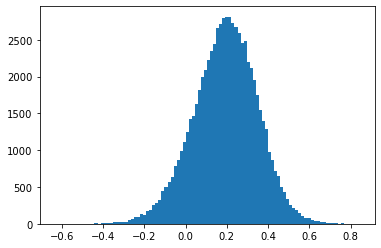

In [321]:
plt.hist(res.flatten(), bins=100);

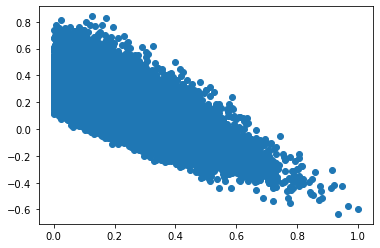

In [322]:
realpix = real[mask > 0]
plt.scatter(realpix, res)

In [235]:

n = np.random.normal(0, 0.4, size=cv.shape)
n = np.where(mask > 0, n, 0)
cv = cv + n
cv = norm(cv)

In [236]:
sim = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/GUB_zld-cterm_20220321-zld-cterm-gfp-em1-01_0_1.pkl')
fm.viewer([cv * 1000, real * 1000],5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

In [170]:
fm.viewer((cv - real) * 1000, 5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

In [197]:
res = real - cv
res = res[mask > 0]

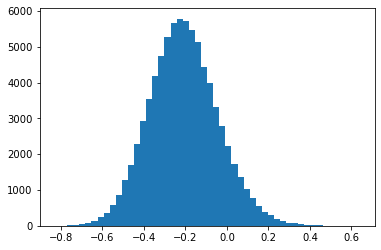

In [198]:
plt.hist(res, bins=50);

In [208]:
import scipy
x = scipy.stats.norm(loc=-0.2, scale=0.15)
#plt.plot(x)


In [220]:
n = np.random.normal(0, 0.15, size=(34,100,100))
n = n - np.min(n)
n = np.where(mask > 0, n, 0)


In [221]:
fm.viewer(n * 1000, 5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

In [345]:
model = tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/trained_models/blackbox')

im = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/Jpb_zld-cterm_20220321-zld-cterm-gfp-em1-01_0_5.pkl')
im[15:18,45:55,45:55] = 0.6
x = np.expand_dims(im, axis=-1)
x = np.expand_dims(x, axis=0)

m = model(x)

fm.viewer(m.numpy() * 1000, 5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

In [3]:
model = tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/trained_models/blackbox2')

im = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/Jpb_zld-cterm_20220321-zld-cterm-gfp-em1-01_0_5.pkl')
im[15:18,45:55,45:55] = 0.6
x = np.expand_dims(im, axis=-1)
x = np.expand_dims(x, axis=0)

m = model(x)

fm.viewer(m.numpy() * 1000, 5)

NameError: name 'tf' is not defined

In [344]:
model = tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/trained_models/blackbox3')

im = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/Jpb_zld-cterm_20220321-zld-cterm-gfp-em1-01_0_5.pkl')
im[15:18,45:55,45:55] = 0.6

x = np.expand_dims(im, axis=-1)
x = np.expand_dims(x, axis=0)

m = model(x)

fm.viewer(m.numpy() * 1000, 5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

Automate: 

In [5]:
kernel = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
kernel = ndi.zoom(kernel, (100/250, 50/85, 50/85))
kernel = kernel / np.sum(kernel)

def conv_psf(im):
    return ndi.convolve(im, kernel)

In [6]:
model1 = tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/trained_models/blackbox')
model2 = tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/trained_models/blackbox2')

def conv_model(im, model):
    x = np.expand_dims(im, axis=-1)
    x = np.expand_dims(x, axis=0)
    m = model(x).numpy()
    return m[0]

conv_model1 = lambda x: conv_model(x, model1)
conv_model2 = lambda x: conv_model(x, model2)

def test(x):
    return x

2022-04-29 10:40:33.118005: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
def get_diff(simfile, conv_func):
    def norm(x, mask):
        vals = x[mask]
        return x / np.mean(vals)
        return (x - np.min(vals)) / (np.max(vals) - np.min(vals))

    def get_real(simfile):
        f = simfile.split('/')[-1]
        return os.path.join('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/reals/', f[4:])

    sim = fm.load_pickle(simfile)
    real = fm.load_pickle(get_real(simfile))

    mask = ndi.morphology.binary_erosion(np.where(real > 0, 1, 0), structure=np.ones((1,7,7)))
    real = norm(real, mask)

    cv = norm(conv_func(sim), mask)
    res = cv - real
    res = res[mask > 0]
    realpix = real[mask > 0]
    return cv, real, mask



In [8]:
res0 = get_diff('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/gPD_zld-cterm_20220321-zld-cterm-gfp-em1-01_5_5.pkl', conv_psf)
res1 = get_diff('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/gPD_zld-cterm_20220321-zld-cterm-gfp-em1-01_5_5.pkl', conv_model1)
res2 = get_diff('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/gPD_zld-cterm_20220321-zld-cterm-gfp-em1-01_5_5.pkl', conv_model2)

In [20]:
im0 = (res0[1] - res0[0]) * 1000
im1 = (res1[1] - res1[0]) * 1000
im2 = (res2[1] - res2[0]) * 1000
g = np.random.normal(np.mean(im0), 300, size=(34,100,100)) * 2
g = np.where(res0[2], g, 0)

fm.viewer([im0, im1, im2, g], 5)

interactive(children=(Dropdown(description='Color', index=2, options=('prism', 'viridis', 'cividis', 'gray', '…

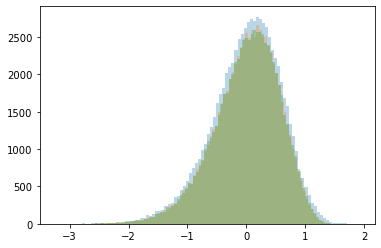

In [403]:
plt.hist(res0[1], bins=100, alpha=0.3);
plt.hist(res1[1], bins=100, alpha=0.3);
plt.hist(res2[1], bins=100, alpha=0.3);

In [404]:
im = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/sims/gPD_zld-cterm_20220321-zld-cterm-gfp-em1-01_5_5.pkl')
cv0 = conv_psf(im)
cv1 = conv_model1(im)
cv2 = conv_model2(im)
real = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/blackbox/reals/zld-cterm_20220321-zld-cterm-gfp-em1-01_5_5.pkl')

In [408]:
fm.viewer([cv1 * 1000, cv2 * 1000, cv0 * 1000, real / 30], 5)

interactive(children=(Dropdown(description='Color', index=10, options=('Reds', 'plasma', 'gray', 'magma', 'inf…

## Conclusions

I'm still a little confused about all this. The basic situation is that I'm dividing the process of converting true images (fluorophore distributions) into images into two parts. The first part is convolution, the second is adding noise. This makes sense and it's what I've been doing for a while.

I've now developed two ways to do the convolution. The first is to use a bead-measured PSF for the microscope to do the convolution. The strength here is we are measuring something off the actual imaging system. The weakness is that we *know* we are measuring the WRONG thing: the real PSF will be different within the sample and will vary with depth.

The second idea is to learn the convolution part using some light ML. For this, we basically need some true images, some real images, and we let the "black box" learn how to convert one to the other. It's not at all clear that we have anything that fits this bill. My stab at it was to assume that C-terminal Zelda was uniformly and randomly distributed. For training data, I simulated a large number of images, each matched to a real nucleus, with different random distributions of fluores according to measured concentrations. I learned the convolution different ways, once using a single convolution layer and filter to learn a PSF, and then two different architectures using multi-filter convolution layers. In the first (model1) I did a 64 filter 3x3 layer and simply summed the outputs to produce an image. In the second (model2) I had the same layer feed to a 1x1 1-filter layer, which should have produced a weighted average of the 64 filters, which seemed like what I wanted. This model didn't do very well: it just learned to find where there is sigmal and produce a uniform signal. In fairness, this could be a consequence of bad training data. Maybe that is what a good algorithm will learn from using only uniform inputs.

I also thought some about what these black boxes will learn. Because each random distribution will be unique and not actually match the real image, and because I don't think it's capable of learning to produce random noise, I think I expect it to learn some kind of average, whatever will reduce the residual to the minimum. That residual is the remaining noise component.

So I ended up trying three different convolutions: measured PSF, blackbox 1 and blackbox 2. I think used these to convolve simulated images and look at the residual after subtracting from real images (* there's some issue about how best to normalize images for comparison but I think I have it ok). The confounding this is that the histograms of the residuals look almost identical for all three approaches.

This is quite surprising. The blackbox convolutions are much "blurrier" (the convolution kernel is much wider and flatter than the sharper PSF) and the convolved images from the real PSF are much sharper. Yet the overall pattern of the residuals are very similar. This could be obscuring spatial correlations, and indeed it is, to some degree. However, looking at the residual images, I think that gaussian noise is probably a fairly decent approximation of this residual.

So what to do?

I think for now I'm going to let this rest. I will try using the learned convolution kernel in some other simulations and compare it to the measured PSF, using a gaussian noise model. This is admittedly close to being back where we started, but I think much was learned.